In [ ]:
"""
This notebook creates a Bayesian structural time series model to estimate the total bike ride demand 
across multiple years. This can then be used for prediction.
"""

import glob
import os

import arviz as az
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle
import pymc as pm

from scipy.ndimage import gaussian_filter

# File name for the final model results
MODEL_RESULTS_FILE = "../models/weekly_demand.nc"

In [2]:
# Load in the data
df_bike = pd.read_pickle("../data/indego_bike_data.pkl")
print(df_bike.head())

       trip_id  duration           start_time             end_time  \
0  144361832.0      12.0  2017-07-01 00:04:00  2017-07-01 00:16:00   
1  144361829.0      31.0  2017-07-01 00:06:00  2017-07-01 00:37:00   
2  144361830.0      15.0  2017-07-01 00:06:00  2017-07-01 00:21:00   
3  144361831.0      15.0  2017-07-01 00:06:00  2017-07-01 00:21:00   
4  144361828.0      30.0  2017-07-01 00:07:00  2017-07-01 00:37:00   

   start_station  start_lat  start_lon  end_station    end_lat    end_lon  \
0         3160.0  39.956619 -75.198624       3163.0  39.949741 -75.180969   
1         3046.0  39.950119 -75.144722       3101.0  39.942951 -75.159554   
2         3006.0  39.952202  -75.20311       3101.0  39.942951 -75.159554   
3         3006.0  39.952202  -75.20311       3101.0  39.942951 -75.159554   
4         3046.0  39.950119 -75.144722       3101.0  39.942951 -75.159554   

  bike_id  plan_duration trip_route_category passholder_type bike_type  
0   11883           30.0             One Wa

So far, I modeled two aspects of bike ride demand: Ride duration and the # number of bike rides per
station for each weekday. But now, I'm curious as to a more high level metric: The *total* number of
bike rides per weekday.

First, I do want to note that while one could just aggregate the sum of rides from all bike stations 
per weekday, this would not be as valid as creating a separate time series model. This model just
aggregates all the Mondays together, all the Tuesdays together, etc., but it has no concept whether
say, a Monday in 2025 is more busy than a Monday in 2023; Each instance of a weekday would be 
considered identical.

The time series model though, can highlight such a possible trend. It focuses on the long-term 
growth or decline on the entire system's ridership, whcih is the most impactful factor for accurate
forecasting. This is also more statistically efficient since the model is built to predict a single 
bike ride count, not multiple bike ride counts. 

With that said, this model is using a Gaussian Random Walk, meaning that the bike ride demand trend
for any given data is assumed to be the same as the previous day, +/- a small random change. This 
allows the model to learn a smooth trend (since it is very unlikely, if at all present, that demamd
would either spike up or down quickly). Given the cyclical nature of weekdays, the model can also 
learn a stable, repeating 7-day cycle for how people use the bikes. This estimates a single, fixed 
effect for every Monday, Tuesday, etc. Finally, by combining the overall trend with the weekday 
effect, a final prediction can be made. This prediction is then combined with the actual data with 
a Negative Binomial likelihood*.

*The Negative Binomial likelihood is chosen as a more flexible and robust alternative to the Poisson
distribution for modeling count data. Most notably, it can handle overdispersion (the Poisson
distribution assumes mean and variance are equal in a dataset), but in the bike data, this likely
would be violated.

In [3]:
# For simplicity, subset to the last two years
df_bike['start_time'] = pd.to_datetime(df_bike['start_time'], format='mixed')
latest_date = df_bike['start_time'].max()
cutoff_date = latest_date - pd.DateOffset(years=2)
df_bike = df_bike[df_bike['start_time'] >= cutoff_date].copy()

# Set 'start_time' as the index and resample to get daily counts
df_daily_rides = df_bike.set_index('start_time').resample('D').size()

# Create a day of the week feature for the seasonality component
day_of_week = df_daily_rides.index.dayofweek

# Convert to numpy values into int64 
day_of_week = day_of_week.values.astype('int64')

print(df_daily_rides.head())

start_time
2023-06-30       7
2023-07-01    3227
2023-07-02    2706
2023-07-03    2916
2023-07-04    3115
Freq: D, dtype: int64


In [9]:
import warnings
warnings.filterwarnings('ignore')

import logging

# 1. Get the specific logger responsible for the rewrite errors
rewrite_logger = logging.getLogger('pytensor.graph.rewriting')
# 2. Set the logger's level to CRITICAL to suppress ERRORs
rewrite_logger.setLevel(logging.CRITICAL)

# 3. (Optional) Suppress general PyMC info/warnings (like 'Initializing NUTS...')
# logger_pymc = logging.getLogger('pymc')
# logger_pymc.setLevel(logging.WARNING) # or logging.ERROR

import pymc as pm
# ... Your PyMC code here (e.g., pm.sample())

In [10]:
n_days_total = len(df_daily_rides)
n_days_week = 7

with pm.Model() as ts_model:
    # --- Weekly Seasonality ---
    # An effect for each day of the week
    week_effect = pm.Normal('week_effect', mu=0, sigma=0.1, shape=n_days_week)
    
    # --- Trend Component (Gaussian Random Walk) ---
    # The 'init_dist' specifies the starting point of the trend
    trend = pm.GaussianRandomWalk('trend', mu=0, sigma=0.1, shape=n_days_total,
                                  init_dist=pm.Normal.dist(mu=np.log(df_daily_rides.iloc[0]), sigma=1))

    # --- Expected Ride Count ---
    # The expected rate is the combination of the trend and the weekly effect
    # for that day, converted from log scale.
    expected_count = pm.math.exp(trend + week_effect[day_of_week])

    # --- Likelihood ---
    # A NegativeBinomial is often more flexible for count data than a Poisson
    # as it can handle overdispersion (more variance than the mean).
    alpha = pm.HalfNormal('alpha', sigma=50) # Overdispersion parameter
    y_obs = pm.NegativeBinomial('y_obs', 
                               mu=expected_count, 
                               alpha=alpha, 
                               observed=df_daily_rides.values)

    # --- MCMC Sampling ---
    idata_ts = pm.sample(
        2000, tune=1000, cores=12, progressbar=True)

# Save the final results to a file for later use
print("\n--- Saving Model Results ---")
idata_ts.to_netcdf(MODEL_RESULTS_FILE)
print(f"Model results saved to {MODEL_RESULTS_FILE}")

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (12 chains in 12 jobs)
NUTS: [week_effect, trend, alpha]


Sampling 12 chains for 1_000 tune and 2_000 draw iterations (12_000 + 24_000 draws total) took 148 seconds.



--- Saving Model Results ---
Model results saved to ../models/weekly_demand.nc


From the model, I can decompose the historical data into the trend and historical components.

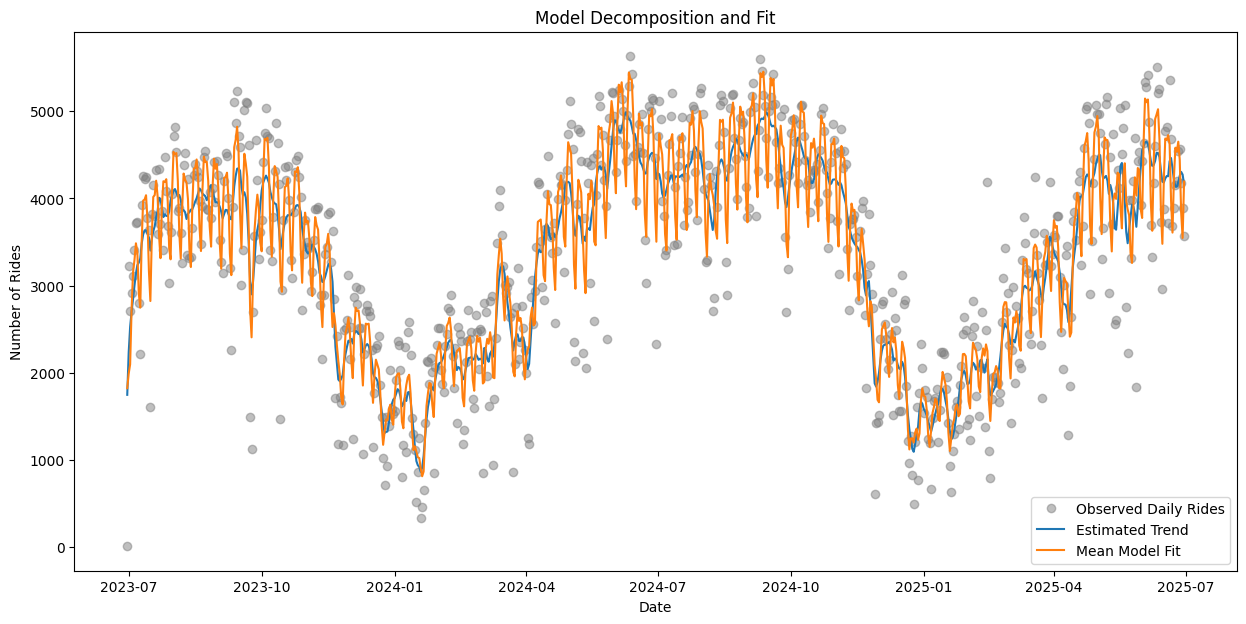

In [11]:
# Extract the posterior mean for the trend and the full model fit
posterior_samples = az.extract(idata_ts)
mean_log_trend = posterior_samples['trend'].mean(dim='sample').values
mean_fit = np.exp(mean_log_trend + posterior_samples['week_effect'].mean(dim='sample').values[day_of_week])

#  Convert the trend back to the original scale 
mean_trend_original_scale = np.exp(mean_log_trend)

# Create the plot
plt.figure(figsize=(15, 7))
plt.plot(df_daily_rides.index, df_daily_rides.values, 'o', color='gray', alpha=0.5, label='Observed Daily Rides')
plt.plot(df_daily_rides.index, mean_trend_original_scale, color='C0', label='Estimated Trend')
plt.plot(df_daily_rides.index, mean_fit, color='C1', label='Mean Model Fit')

plt.title('Model Decomposition and Fit')
plt.xlabel('Date')
plt.ylabel('Number of Rides')
plt.legend()
plt.show()

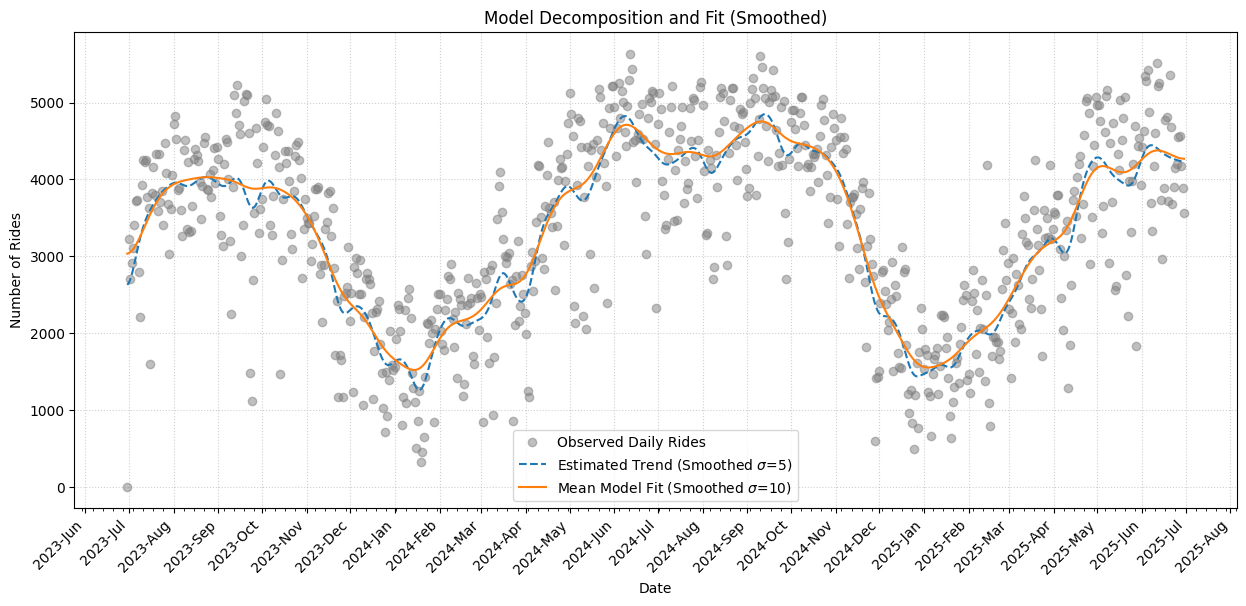

In [13]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter
import arviz as az 
import matplotlib.dates as mdates # 👈 Import for date handling

# --- Your existing setup and smoothing code ---

# Extract the posterior mean for the trend and the full model fit
posterior_samples = az.extract(idata_ts)
mean_log_trend = posterior_samples['trend'].mean(dim='sample').values
mean_fit = np.exp(mean_log_trend + posterior_samples['week_effect'].mean(dim='sample').values[day_of_week])

# Convert the trend back to the original scale 
mean_trend_original_scale = np.exp(mean_log_trend)

# Smoothing parameters
SMOOTHING_SIGMA_TREND = 5
SMOOTHING_SIGMA_FIT = 10 

# Apply Gaussian smoothing to the trend
smoothed_trend = gaussian_filter(
    input=mean_trend_original_scale, 
    sigma=SMOOTHING_SIGMA_TREND, 
    mode='reflect'
)

# Apply Gaussian smoothing to the mean fit
smoothed_fit = gaussian_filter(
    input=mean_fit, 
    sigma=SMOOTHING_SIGMA_FIT, 
    mode='reflect'
)

# -----------------------------------------------------------
# 🌟 DATE TICK ADJUSTMENT 🌟
# -----------------------------------------------------------

# Create the plot figure and axes object
fig, ax = plt.subplots(figsize=(15, 7))

# Plotting
ax.plot(df_daily_rides.index, df_daily_rides.values, 'o', color='gray', alpha=0.5, label='Observed Daily Rides')
ax.plot(df_daily_rides.index, smoothed_trend, 
        color='C0', 
        linestyle='--', 
        label=f'Estimated Trend (Smoothed $\\sigma$={SMOOTHING_SIGMA_TREND})')
ax.plot(df_daily_rides.index, smoothed_fit, 
        color='C1', 
        label=f'Mean Model Fit (Smoothed $\\sigma$={SMOOTHING_SIGMA_FIT})')

# 1. Set the Locator (how often ticks appear)
# Options: DayLocator(), WeekdayLocator(interval=1), MonthLocator(), YearLocator()
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1)) # Show a tick for the start of every month

# 2. Set the Formatter (how the ticks are labeled)
# Common formats: '%Y-%m' (2025-08), '%b %d' (Aug 24), '%Y\n%b' (2025\nAug)
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%b')) # Format as Year-Abbreviated Month (e.g., 2025-Aug)

# 3. Rotate and align labels (optional, but often needed for dense dates)
fig.autofmt_xdate(rotation=45, ha='right')

# Add minor ticks for every week (optional, adds more granularity)
ax.xaxis.set_minor_locator(mdates.WeekdayLocator(interval=1))


# Final plot formatting
ax.set_title('Model Decomposition and Fit (Smoothed)')
ax.set_xlabel('Date')
ax.set_ylabel('Number of Rides')
ax.legend()
ax.grid(True, linestyle=':', alpha=0.6)
plt.show()

And of course, what about the forecast of future ridership?

C:\Users\kevin\AppData\Local\Temp\ipykernel_25092\2705668114.py:54: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi_data = az.hdi(forecast_values, hdi_prob=0.94).T


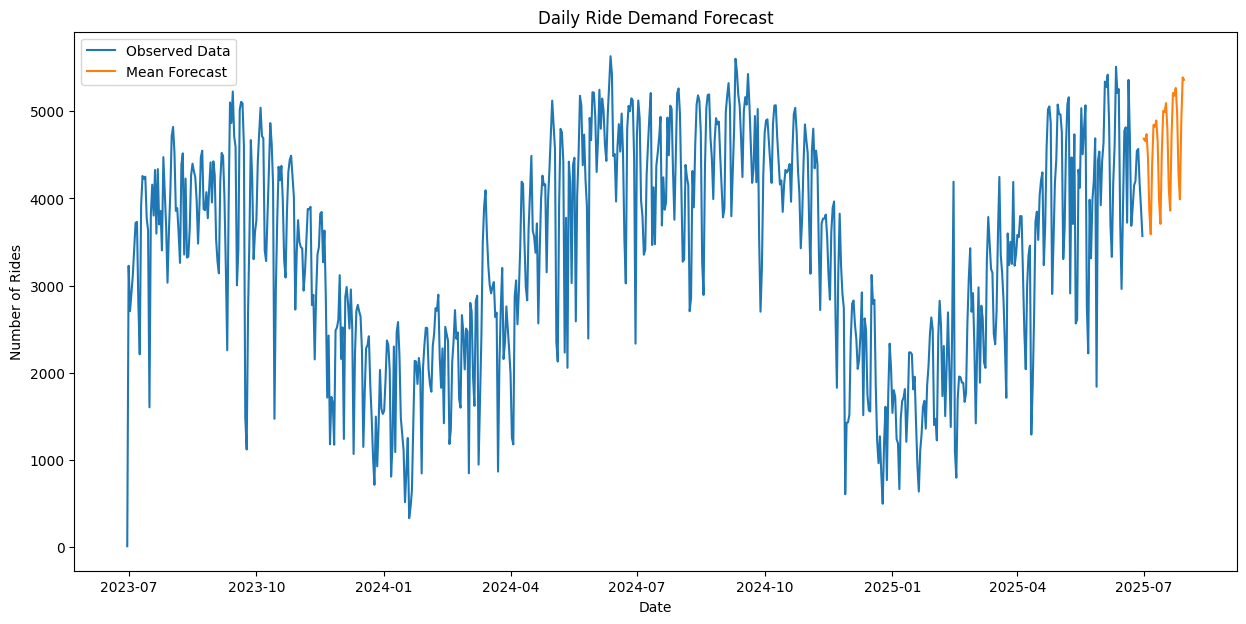

In [6]:
import arviz as az
import numpy as np
from scipy.stats import nbinom
import pandas as pd
import matplotlib.pyplot as plt

# --- 2. Extract Posterior Samples ---
# Extract the full posterior dataset
posterior_samples = az.extract(idata_ts)

# Extract each variable using its name
last_day_trend = posterior_samples['trend'].isel(trend_dim_0=-1)
week_effect_samples = posterior_samples['week_effect']
alpha_samples = posterior_samples['alpha']
trend_sigma = 0.1 # Using the fixed value

# --- Define n_samples ---
n_samples = len(last_day_trend)

# --- 3. Manually Simulate the Forecast ---
n_forecast_days = 30
forecast_dates = pd.date_range(start=df_daily_rides.index[-1] + pd.Timedelta(days=1), periods=n_forecast_days)
forecast_day_of_week = forecast_dates.dayofweek

forecast_values = np.zeros((n_samples, n_forecast_days))

# Loop through each posterior sample to create a full distribution of forecasts
for i in range(n_samples):
    # --- Use .isel(sample=i) for correct indexing ---
    current_trend = last_day_trend.isel(sample=i).values
    current_week_effect_sample = week_effect_samples.isel(sample=i).values
    current_alpha_sample = alpha_samples.isel(sample=i).values
    
    for t in range(n_forecast_days):
        current_trend += np.random.normal(0, trend_sigma)
        
        day_effect = current_week_effect_sample[forecast_day_of_week[t]]
        expected_count = np.exp(current_trend + day_effect)
        
        # The nbinom.rvs function needs p, not mu and alpha. We convert first.
        p = expected_count / (expected_count + current_alpha_sample)
        forecast_values[i, t] = nbinom.rvs(n=current_alpha_sample, p=1-p)

# --- 4. Plot the Forecast ---
plt.figure(figsize=(15, 7))
plt.plot(df_daily_rides.index, df_daily_rides.values, label='Observed Data')

# Plot the mean forecast
plt.plot(forecast_dates, forecast_values.mean(axis=0), color='C1', label='Mean Forecast')

# --- Manually calculate and plot the HDI ---
# Calculate the HDI from the original forecast_values array
# The result will have shape (2, 30), so we transpose it to (30, 2)
hdi_data = az.hdi(forecast_values, hdi_prob=0.94).T

# Use fill_between to plot the uncertainty interval
# plt.fill_between(
#     forecast_dates,
#     hdi_data[:, 0], # Lower bound of the HDI
#     hdi_data[:, 1], # Upper bound of the HDI
#     color='C1',
#     alpha=0.2,
#     label='94% HDI'
# )

plt.title('Daily Ride Demand Forecast')
plt.xlabel('Date')
plt.ylabel('Number of Rides')
plt.legend()
plt.show()